# Implementation and Analysis of TSP Algorithms

#### Dependencies

In [172]:
import time
import matplotlib.pyplot as plt
import numpy as np
from functools import partial
import networkx as nx
from collections import defaultdict
import heapq
import copy 
import random

def complete_graph(n):
    G = nx.complete_graph(n, create_using = nx.Graph)
    for u, v, d in G.edges(data=True):
        d['weight'] = random.randrange(0, 10)
    return G
        

## Exact Algorithm

#### Held-Karp Algorithm

In [173]:
def held_karp(G):
    pass

## Approximation Algorithms

#### Pairwise Exchange Algorithm

In [174]:
# Calculate the change in the total weight of path
def cost_change(cost_mat, n1, n2, n3, n4):
    return cost_mat[n1][n3] + cost_mat[n2][n4] - cost_mat[n1][n2] - cost_mat[n3][n4]


# Takes in an adjacency matrix and arbitrary route

def two_opt(route, cost_mat):
    best = route
    improved = True
    while improved:
        improved = False
        for i in range(1, len(route) - 2):
            for j in range(i + 1, len(route)):
                # Continue if the edges have shared nodes
                if j - i == 1: continue
                if cost_change(cost_mat, best[i - 1]-1, best[i]-1, best[j - 1]-1, best[j]-1) < 0:
                    # Swap the edges if the path improves
                    best[i:j] = best[j - 1:i - 1:-1]
                    improved = True
        route = best
    return best


#### Christofides-Serdyukov Algorithm

In [175]:
def odd_vertices(T: nx.Graph):
    odd_set = set()
    for v in T:
        if nx.degree(T, v)%2 == 1:
            odd_set.add(v)
    return odd_set

def min_match(G):
    matching = nx.Graph()
    for v in G:
        #print(v)
        mydict = {}
        for u in G[v]:
            if u not in matching and v not in matching:
                mydict[u] = G[v][u]['weight']
            
        if v != None and mydict:
            x = min(mydict, key = mydict.get)
            matching.add_node(v)
            matching.add_node(x)
            matching.add_weighted_edges_from([(v, x, G[v][u]['weight'])])
    return matching 



def chirstoalgo(G, v):
    min_tree = nx.minimum_spanning_tree(G, v)
    x = odd_vertices(min_tree)
    sub = G.subgraph(x)
    matching = min_match(sub)

    multi = nx.MultiGraph()
    multi.add_weighted_edges_from(min_tree.edges(data='weight'))
    multi.add_weighted_edges_from(matching.edges(data='weight'))
    multi.add_nodes_from(min_tree.nodes())

    e_circ = [u for u,x in nx.eulerian_circuit(multi, source=v)] 
    tsp_path = list(dict.fromkeys(e_circ))
    tsp_path.append(v)
    return tsp_path

( 0 1 5 ) ( 0 2 9 ) ( 0 3 7 ) ( 1 2 3 ) ( 1 3 0 ) ( 2 3 2 ) 

[1, 0, 3, 2, 1]

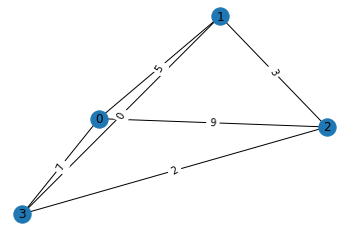

In [176]:
G = complete_graph(4)
for u, v, d in G.edges(data=True):
        print("(",u, v, d['weight'], ")", end=" ")
pos = nx.spring_layout(G)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
nx.draw(G, pos, with_labels=True)
chirstoalgo(G, 1)

#### Nearest Neighbors Algorithm

In [177]:
def n_neighbors(G):
    pass

## Empirical Analysis

In [180]:
def Empirical_Analysis(n, repeat):
    
    hk_runtimes = []
    nn_runtimes = []
    cs_runtimes = []
    pe_runtimes = []
    
    n_values = np.array([i for i in range(1, n)])
    
    for i in n_values:
        
        G = complete_graph(i)
        start_time = time.time()
        chirstoalgo(G, 1)
        cs_runtimes.append((time.time()-start_time))
        
        
        
#         nn_runtimes.append(min(timeit.Timer(partial(n_neighbors, G)).repeat(3, repeat))/repeat)
#         cs_runtimes.append(min(timeit.Timer(chirstoalgo(G, 1)).repeat(3, repeat))/repeat)

#         if (i < 10):
#             hk_runtimes.append(min(timeit.Timer(partial(held_karp, G)).repeat(3, repeat))/repeat)

    
            
    
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].plot(n_values, hk_runtimes)
    axs[0, 0].set_title("Held-Karp")
    axs[1, 0].plot(n_values, nn_runtimes)
    axs[1, 0].set_title("Nearest Neighbor")

    axs[0, 1].plot(n_values, cs_runtimes)
    axs[0, 1].set_title("Christofides")
    axs[1, 1].plot(n_values, pe_runtimes)
    axs[1, 1].set_title("Pairwise Exchange")
    fig.tight_layout()
    plt.show()
    
    return
    

In [181]:
Empirical_Analysis(5, 10)

NetworkXError: nbunch is not a node or a sequence of nodes.